In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns 

In [ ]:
dataframe = pd.read_csv('Dataset_1966.csv')
df = dataframe[['Date', 'WL']]
df['Date'] = pd.to_datetime(df['Date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


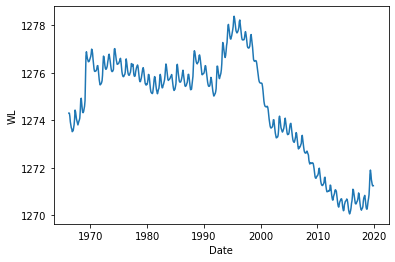

In [ ]:
sns.lineplot(x=df['Date'], y=df['WL'])

In [ ]:
print("Start date is: ", df['Date'].min())
print("End date is: ", df['Date'].max())

Start date is:  1966-04-01 00:00:00
End date is:  2019-11-01 00:00:00


In [ ]:
#Change train data from Mid 2017 to 2019.... seems to be a jump early 2017
train, test = df.loc[df['Date'] <= '1992-04-01'], df.loc[df['Date'] > '1992-04-01']

In [ ]:
#Convert pandas dataframe to numpy array
#dataset = dataframe.values
#dataset = dataset.astype('float32') #COnvert values to float

In [ ]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
#scaler = MinMaxScaler() #Also try QuantileTransformer
scaler = StandardScaler()
scaler = scaler.fit(train[['WL']])

In [ ]:
train['WL'] = scaler.transform(train[['WL']])
test['WL'] = scaler.transform(test[['WL']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 2. We will make timesteps = 3. 
#With this, the resultant n_samples is 5 (as the input data has 9 rows).

In [ ]:
seq_size = 24  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.


In [ ]:
def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

In [ ]:
trainX, trainY = to_sequences(train[['WL']], train['WL'], seq_size)
testX, testY = to_sequences(test[['WL']], test['WL'], seq_size)
#print(trainX)

In [ ]:
# define Autoencoder model
#Input shape would be seq_size, 1 - 1 beacuse we have 1 feature. 
#seq_size = trainX.shape[1]

In [ ]:
# model = Sequential()
# model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
# model.add(LSTM(64, activation='relu', return_sequences=False))
# model.add(RepeatVector(trainX.shape[1]))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(trainX.shape[2])))

# model.compile(optimizer='adam', loss='mse')
# model.summary()

In [ ]:
#Try another model
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
model.add(Dropout(rate=0.3))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.3))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 24, 128)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 24, 128)           131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 24, 128)           0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 24, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

In [ ]:
# fit model
history = model.fit(trainX, trainY, epochs=300,  validation_split=0.2, batch_size=12, verbose=1)

Epoch 1/300
20/20 [==============================] - 6s 100ms/step - loss: 0.4248 - val_loss: 0.3386
Epoch 2/300
20/20 [==============================] - 1s 55ms/step - loss: 0.3178 - val_loss: 0.2786
Epoch 3/300
20/20 [==============================] - 1s 56ms/step - loss: 0.2950 - val_loss: 0.2603
Epoch 4/300
20/20 [==============================] - 1s 55ms/step - loss: 0.2316 - val_loss: 0.2375
Epoch 5/300
20/20 [==============================] - 1s 55ms/step - loss: 0.2293 - val_loss: 0.1996
Epoch 6/300
20/20 [==============================] - 1s 57ms/step - loss: 0.1820 - val_loss: 0.1674
Epoch 7/300
20/20 [==============================] - 1s 57ms/step - loss: 0.2010 - val_loss: 0.1481
Epoch 8/300
20/20 [==============================] - 1s 57ms/step - loss: 0.1773 - val_loss: 0.1455
Epoch 9/300
20/20 [==============================] - 1s 55ms/step - loss: 0.1566 - val_loss: 0.1397
Epoch 10/300
20/20 [==============================] - 1s 56ms/step - loss: 0.1593 - val_loss: 0.156

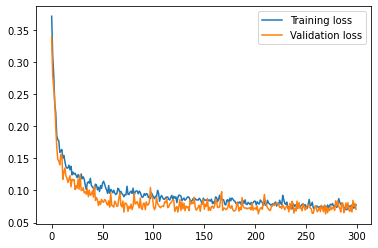

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
#model.evaluate(testX, testY)

In [ ]:
###########################
#Anomaly is where reconstruction error is large.
#We can define this value beyond which we call anomaly.
#Let us look at MAE in training prediction

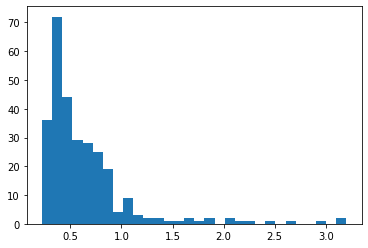

In [ ]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)
max_trainMAE = 2.5 #or Define 90% value of max as threshold.

(array([28., 26., 38., 34., 16., 15., 12.,  5.,  2.,  4.,  2.,  2.,  2.,
         3.,  2.,  4.,  3.,  3.,  3.,  5.,  4.,  4.,  4.,  5.,  5.,  4.,
         9.,  6., 41., 16.]),
 array([0.50394609, 0.6523591 , 0.80077211, 0.94918512, 1.09759813,
        1.24601114, 1.39442415, 1.54283716, 1.69125017, 1.83966318,
        1.98807619, 2.1364892 , 2.28490221, 2.43331522, 2.58172823,
        2.73014124, 2.87855425, 3.02696726, 3.17538027, 3.32379328,
        3.47220629, 3.6206193 , 3.76903231, 3.91744532, 4.06585833,
        4.21427134, 4.36268435, 4.51109736, 4.65951037, 4.80792338,
        4.95633639]),
 <a list of 30 Patch objects>)

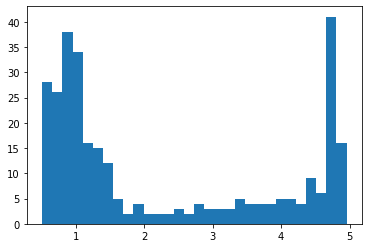

In [ ]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

In [ ]:
#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['WL'] = test[seq_size:]['WL']

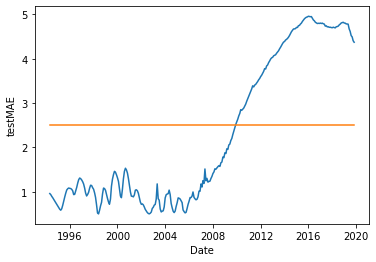

In [ ]:
#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])

In [ ]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
#print(anomalies)

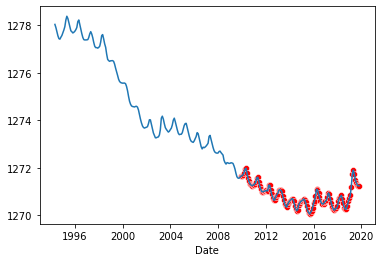

In [ ]:
#Plot anomalies
sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['WL']))
sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['WL']), color='r')
